In [1]:
# Instalando conda (mamba)
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [1]:
# Instalando pacotes necessários
!mamba install -c conda-forge cartopy siphon metpy imgaug
!apt-get -qq install libproj-dev libgeos-dev
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
!pip install pyyaml==5.4.1


Looking for: ['cartopy', 'siphon', 'metpy', 'imgaug']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   1%
conda-forge/noarch    11%[+] 0.3s
conda-forge/linux-64  11%
conda-forge/noarch    21%[+] 0.4s
conda-forge/linux-64  16%
conda-forge/noarch    41%[+] 0.5s
conda-forge/linux-64  20%
conda-forge/noarch    52%[+] 0.6s
conda-forge/linux-64  25%
conda-forge/noarch    63%[+] 0.7s
conda-forge/linux-64  30%
conda-forge/noarch    74%[+] 0.8s
conda-forge/linux-64  34%
conda-forge/noarch    85%[+] 0.9s
conda-forge/linux-64  39%
conda-forge/noarch    96%conda-forge/noarch                                
[+] 1.0s
conda-forge/linux-64  43%[+] 1.1s
conda-forge/linux-64  48%[+] 1.2s
conda-forge/linux-64  57%[+] 1.3s
conda-forge/linux-64  67%[+] 1.4s
conda-forge/linux-64  81%[+] 1.5s
conda-forge/linux-64  90%conda-forge/linux-64                              

Pinned packages:
  - python 3.10.*
  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - c

In [2]:
# A whole bunch of imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
from netCDF4 import num2date
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog
import xarray as xr
from datetime import datetime
import numpy as np
import numpy.ma as ma
from metpy.io import GiniFile
from metpy.plots.ctables import registry
from metpy.units import units
import metpy.calc as mpcalc

In [3]:
dt = datetime(2024, 6, 5, 12)

# Assemble our URL to the THREDDS Data Server catalog,
# and access our desired dataset within via NCSS
#base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_onedeg_ana/GFS_Global_onedeg_ana_'
base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg_ana/GFS_Global_0p25deg_ana_'
cat = TDSCatalog(f'{base_url}{dt:%Y%m%d}_{dt:%H}00.grib2/catalog.xml')
ncss = cat.datasets[0].subset()

# Setando
nivel_vento1 = 500
nivel_vento2 = 1000
nivel_esp1 = 500
nivel_esp2 = 1000
lat_sul = -70
lat_norte = -15
lon_leste = 360
lon_oeste = 230
lon_l = lon_leste - 360
lon_o = lon_oeste - 360

# Vento nível superior
query_vento1 = ncss.query()
query_vento1.variables('u-component_of_wind_isobaric',
                     'v-component_of_wind_isobaric').add_lonlat().accept('netcdf')
query_vento1.vertical_level(nivel_vento1 * 100)
query_vento1.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_vento1 = ncss.get_data(query_vento1)

# V2 wind data
query_vento2 = ncss.query()
query_vento2.variables('u-component_of_wind_isobaric',
                    'v-component_of_wind_isobaric').add_lonlat().accept('netcdf')
query_vento2.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
query_vento2.vertical_level(nivel_vento2 * 100)
data_vento2 = ncss.get_data(query_vento2)

# MSLP
query_mslp = ncss.query()
query_mslp.variables('Pressure_reduced_to_MSL_msl').add_lonlat().accept('netcdf')
query_mslp.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_mslp = ncss.get_data(query_mslp)

# Esp nivel superior
query_hght1 = ncss.query()
query_hght1.variables('Geopotential_height_isobaric').add_lonlat().accept('netcdf')
query_hght1.vertical_level(nivel_esp1 * 100)
query_hght1.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_hght1 = ncss.get_data(query_hght1)

# Esp nivel inferior
query_hght2 = ncss.query()
query_hght2.variables('Geopotential_height_isobaric').add_lonlat().accept('netcdf')
query_hght2.vertical_level(nivel_esp2 * 100)
query_hght2.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_hght2 = ncss.get_data(query_hght2)

In [4]:
# Tem que fazer esta alteração para conseguir plotar o vento
lon =  data_mslp.variables['longitude'][:]
for i in range(len(lon)):
    if lon[i]>180:
        lon[i] = lon[i]-360

In [5]:
# Grab MSLP and smooth, use MetPy Units module for conversion
emsl_var = data_mslp.variables['Pressure_reduced_to_MSL_msl']
EMSL = units.Quantity(emsl_var[:], emsl_var.units).to('hPa')
mslp = gaussian_filter(EMSL[0], sigma=1.0)

uwnd_nivel1 = data_vento1.variables['u-component_of_wind_isobaric'][:].squeeze()
vwnd_nivel1 = data_vento1.variables['v-component_of_wind_isobaric'][:].squeeze()
uwnd_nivel2 = data_vento2.variables['u-component_of_wind_isobaric'][:].squeeze()
vwnd_nivel2 = data_vento2.variables['v-component_of_wind_isobaric'][:].squeeze()
hght1 = data_hght1.variables['Geopotential_height_isobaric'][:].squeeze()
hght2 = data_hght2.variables['Geopotential_height_isobaric'][:].squeeze()

U_nivel1 = units('m/s') * ndimage.gaussian_filter(uwnd_nivel1, sigma=1, order=0)
V_nivel1 = units('m/s') * ndimage.gaussian_filter(vwnd_nivel1, sigma=1, order=0)
U_nivel2 = units('m/s') * ndimage.gaussian_filter(uwnd_nivel2, sigma=1, order=0)
V_nivel2 = units('m/s') * ndimage.gaussian_filter(vwnd_nivel2, sigma=1, order=0)
Z1 = units.meter * ndimage.gaussian_filter(hght1, sigma=1, order=0)
Z2 = units.meter * ndimage.gaussian_filter(hght2, sigma=1, order=0)

#lon = data_hght.variables['lon'][:]
lat = data_mslp.variables['latitude'][:]
time = data_mslp.variables[data_mslp.variables['Pressure_reduced_to_MSL_msl'].dimensions[0]]
vtime = num2date(time[:], time.units)

In [6]:
# Calculate and smooth 1000-500 hPa thickness
DZ = units.meter * gaussian_filter(Z1 - Z2, sigma=1.0)

#Calculate Thermal Wind components
vt_u = (U_nivel1 - U_nivel2)  # *units('m/s') is not necessary
vt_v = (V_nivel1 - V_nivel2)  # *units('m/s') is not necessary

vt_u = units.Quantity(vt_u, "m/s")
vt_v = units.Quantity(vt_v, "m/s")


/usr/local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


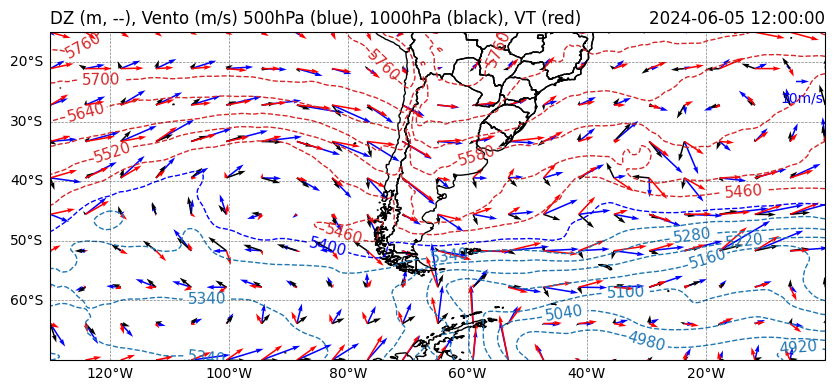

In [7]:
# Create the figure
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=datacrs)

# Add mapping information
# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())

# Plot MSLP
#clevmslp = np.arange(800., 1120., 4)
#ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())
#cs = ax.contour(lon, lat,mslp, clevmslp, colors='black', linewidths=1.0,linestyles='solid',transform=ccrs.PlateCarree())
#ax.clabel(cs, fontsize=12, colors='black', inline=1, inline_spacing=8,
#          fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot thickness with multiple colors
clevs = (np.arange(0, 5400, 60),
         np.array([5400]),
         np.arange(5460, 7000, 60))
colors = ('tab:blue', 'b', 'tab:red')
kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
for clevthick, color in zip(clevs, colors):
    cs = ax.contour(lon, lat, DZ, levels=clevthick, colors=color,
                    linewidths=1.0, linestyles='dashed', transform=ccrs.PlateCarree())
    plt.clabel(cs, **kw_clabels)

uv1 = ax.quiver(lon, lat, U_nivel1, V_nivel1, color='blue',regrid_shape=10,
          width=0.002, scale = 600, transform=ccrs.PlateCarree())
uv2 = ax.quiver(lon, lat, U_nivel2, V_nivel2, color='black',regrid_shape=10,
          width=0.002, scale = 600, transform=ccrs.PlateCarree())
uvt = ax.quiver(lon, lat, vt_u, vt_v, color='red',regrid_shape=10,
          width=0.002, scale = 600, transform=ccrs.PlateCarree())

#Draw the wind field, and after the arrow shaft, you have to explain the relationship between the length of the shaft and the wind speed
#Calling quiver can generate reference arrow + label.
ax.quiverkey(uv1,                     #Incoming quiver handle
             X=0.97, Y = 0.85,       #Determine the location of label, all limited to [0,1]
             U = 10,                    #Reference arrow length means the wind speed is 5m/s.
             angle = 0,            #Reference arrow placement angle. The default is 0, which means horizontal placement
             label='10m/s',        #Arrow's supplement: label's content +
             labelpos='S',          #label is in which direction of the reference arrow; S means south
             color = 'blue',labelcolor = 'blue', #Arrow color + label color
             )
#ax.streamplot(lon, lat, U_nivel, V_nivel, density=[0.5, 1],color='red', linewidth=1, cmap='autumn')
ax.set_title(f'DZ (m, --), Vento (m/s) {nivel_vento1}hPa (blue), {nivel_vento2}hPa (black), VT (red) ', loc='left')
ax.set_title('{}'.format(vtime[0]), loc='right')

# Adding grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlines = True

# Salva o grafico no disco
#plt.savefig("mslp_esp_jato.png", dpi=600, bbox_inches="tight")

##